In [7]:
%matplotlib inline
from __future__ import division,print_function
import numpy as np
from matplotlib import pyplot as plt

import itertools


import pandas as pd
import PIL
from PIL import Image

import scipy

from scipy.ndimage import imread
from sklearn.metrics import confusion_matrix
import bcolz

import theano
from theano import shared, tensor as T
from theano.tensor.nnet import conv2d, nnet
from theano.tensor.signal import pool

import keras
from keras import backend as K

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional

from keras.layers.core import Flatten, Dense, Dropout, Lambda

from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam

from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence


In [2]:
from keras.datasets import mnist

## Data setup

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
X_train = np.expand_dims(X_train,1)
y_train = np.expand_dims(y_train,1)
X_test = np.expand_dims(X_test,1)
y_test = np.expand_dims(y_test,1)

In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
tr_mean = X_train.mean().astype(np.float32())
tr_std = X_train.std().astype(np.float32())
def normalize(x): return (x-tr_mean)/tr_std

In [10]:
gen = image.ImageDataGenerator()

In [11]:
batches = gen.flow(X_train, y_train, batch_size=64)
test_batches = gen.flow(X_test, y_test, batch_size=64)

## Make a linear model



In [12]:
def make_linear_model():
    model = Sequential([
        Lambda(normalize,input_shape=(1,28,28)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(),loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
lm = make_linear_model()

In [14]:
lm.fit_generator(batches, batches.N,nb_epoch=5,validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/5
60000/60000 [==============================] - 12s - loss: 0.4326 - acc: 0.8737 - val_loss: 0.2969 - val_acc: 0.9128
Epoch 2/5
60000/60000 [==============================] - 11s - loss: 0.2993 - acc: 0.9147 - val_loss: 0.2843 - val_acc: 0.9167
Epoch 3/5
60000/60000 [==============================] - 11s - loss: 0.2850 - acc: 0.9200 - val_loss: 0.2824 - val_acc: 0.9186
Epoch 4/5
60000/60000 [==============================] - 11s - loss: 0.2783 - acc: 0.9221 - val_loss: 0.2817 - val_acc: 0.9219
Epoch 5/5
60000/60000 [==============================] - 12s - loss: 0.2724 - acc: 0.9241 - val_loss: 0.2776 - val_acc: 0.9219


### Try out some different learning rates and epochs

In [15]:
K.set_value(lm.optimizer.lr,0.0001)

In [16]:
lm.fit_generator(batches, batches.N,nb_epoch=3,validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/3
60000/60000 [==============================] - 11s - loss: 0.2516 - acc: 0.9299 - val_loss: 0.2638 - val_acc: 0.9257
Epoch 2/3
60000/60000 [==============================] - 11s - loss: 0.2489 - acc: 0.9318 - val_loss: 0.2666 - val_acc: 0.9253
Epoch 3/3
60000/60000 [==============================] - 11s - loss: 0.2477 - acc: 0.9312 - val_loss: 0.2619 - val_acc: 0.9264


## Make a Neural Net Model (Single dense hidden layer, Fully Connected)

In [17]:
def dense_model():
    model = Sequential([
        Lambda(normalize,input_shape=(1,28,28)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
dm = dense_model()

In [19]:
dm.fit_generator(batches, batches.N,nb_epoch=1, validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 12s - loss: 0.1915 - acc: 0.9408 - val_loss: 0.0979 - val_acc: 0.9684


### Try out some different learning rates and number of epochs

In [20]:
K.set_value(dm.optimizer.lr,0.0001)

In [21]:
dm.fit_generator(batches, batches.N,nb_epoch=3, validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/3
60000/60000 [==============================] - 12s - loss: 0.0602 - acc: 0.9824 - val_loss: 0.0727 - val_acc: 0.9768
Epoch 2/3
60000/60000 [==============================] - 12s - loss: 0.0468 - acc: 0.9871 - val_loss: 0.0614 - val_acc: 0.9809
Epoch 3/3
60000/60000 [==============================] - 12s - loss: 0.0396 - acc: 0.9894 - val_loss: 0.0642 - val_acc: 0.9803


Accuracy is much higher with a fully connected model. We are slightly overfitting here, with the higher training accuracy than validation accuracy

## Make a CNN Model

In [22]:
def cnn_model():
    model = Sequential([
        Lambda(normalize,input_shape=(1,28,28)),
        Convolution2D(64,3,3,activation='relu'),
        MaxPooling2D(),
        Convolution2D(124,3,3,activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512,activation='relu'),
        Dense(10,activation='softmax')        
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
cn = cnn_model()

In [24]:
cn.fit_generator(batches, batches.N,nb_epoch=1, validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 17s - loss: 0.1027 - acc: 0.9687 - val_loss: 0.0394 - val_acc: 0.9868


learning rate defaults to 0.001

### Try out some different learning rates and number of epochs:

In [25]:
K.set_value(cn.optimizer.lr, 0.00001)

In [26]:
cn.fit_generator(batches, batches.N,nb_epoch=3, validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/3
60000/60000 [==============================] - 18s - loss: 0.0249 - acc: 0.9923 - val_loss: 0.0252 - val_acc: 0.9921
Epoch 2/3
60000/60000 [==============================] - 17s - loss: 0.0201 - acc: 0.9940 - val_loss: 0.0234 - val_acc: 0.9925
Epoch 3/3
60000/60000 [==============================] - 17s - loss: 0.0183 - acc: 0.9946 - val_loss: 0.0250 - val_acc: 0.9919


We are now getting fantastic accuracy, but overfitting.

## Data Augmentation

Adding data augmentation will help strengthen our model and reduce overfitting (some overfitting seen above)

In [27]:
gen = image.ImageDataGenerator(rotation_range=5, width_shift_range=0.05, height_shift_range=0.05, zoom_range=0.08, shear_range=-0.05, channel_shift_range=0.1)

In [28]:
batches = gen.flow(X_train,y_train, batch_size=64)
test_batches = gen.flow(X_test, y_test, batch_size=64)

In [29]:
cn.fit_generator(batches, batches.N,nb_epoch=1,validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 21s - loss: 0.0539 - acc: 0.9827 - val_loss: 0.0467 - val_acc: 0.9835


### Try out some different learning rates and number of epochs

In [30]:
K.set_value(cn.optimizer.lr,0.00001)

In [31]:
cn.fit_generator(batches, batches.N,nb_epoch=5,validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/5
60000/60000 [==============================] - 21s - loss: 0.0493 - acc: 0.9842 - val_loss: 0.0524 - val_acc: 0.9834
Epoch 2/5
60000/60000 [==============================] - 20s - loss: 0.0478 - acc: 0.9851 - val_loss: 0.0470 - val_acc: 0.9846
Epoch 3/5
60000/60000 [==============================] - 20s - loss: 0.0445 - acc: 0.9860 - val_loss: 0.0454 - val_acc: 0.9865
Epoch 4/5
60000/60000 [==============================] - 20s - loss: 0.0444 - acc: 0.9857 - val_loss: 0.0443 - val_acc: 0.9854
Epoch 5/5
60000/60000 [==============================] - 21s - loss: 0.0425 - acc: 0.9868 - val_loss: 0.0424 - val_acc: 0.9850


Accuracy has gone down as a result of the data we've introduced. We should be able to get it back up with Batch Normalization

### Lets see what our data looks like now

I went through the steps below a series of times, tweaking the Image Generator parameters above until the numbers all looked like numbers that might truly exist in the dataset.

In [36]:
images,labels = next(batches)

In [37]:
images = np.array(images)
images = images.transpose(0,2,3,1) #batch channel width height -> batch width height channel
images = np.squeeze(images) #removes the final dimension, which is required for matplotlib imread comman

In [38]:
def build_fig(images,nshow, rows):
    fig = plt.figure()
    for i in range(1,nshow+1):
        a = fig.add_subplot(rows,nshow/rows,i)
        a.axis('Off')
        img = plt.imshow(images[i],cmap='gray')

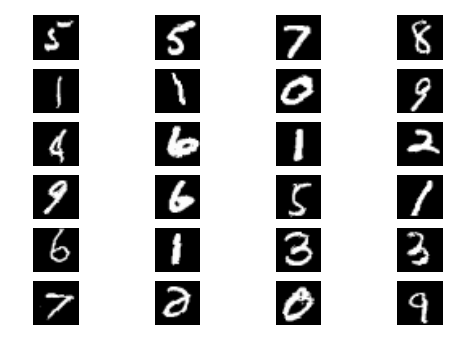

In [39]:
build_fig(images,24,6)

I adjusted the ImageDataGenerator parameters until these all looked like numbers again

## Batch Normalization

It is debatable whether data augmentation should be used in concert with Batch Normalization, but for the purposes of this excercise, I will use both. Because Batch Normalization trains a model much faster (requires fewer epochs), it sees the training data fewer times, which reduces the likelihood of overfitting. So less data (aka a higher percentage of 'real' data) is providing more accurate results. 

In [40]:
def make_cnn_bn():
    model = Sequential([
        Lambda(normalize,input_shape=(1,28,28)),
        Convolution2D(64,3,3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(128,3,3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(100,activation='relu'),
        BatchNormalization(axis=1),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(),loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
bnm = make_cnn_bn()

In [42]:
bnm.fit_generator(batches,batches.N,nb_epoch=1, validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/1
60000/60000 [==============================] - 30s - loss: 0.1253 - acc: 0.9620 - val_loss: 0.0493 - val_acc: 0.9837


### Try out some different learning rates and number of epochs

In [43]:
K.set_value(bnm.optimizer.lr,0.0001)

In [44]:
bnm.fit_generator(batches,batches.N,nb_epoch=10, validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/8
60000/60000 [==============================] - 30s - loss: 0.0503 - acc: 0.9849 - val_loss: 0.0376 - val_acc: 0.9880
Epoch 2/8
60000/60000 [==============================] - 31s - loss: 0.0413 - acc: 0.9876 - val_loss: 0.0318 - val_acc: 0.9897
Epoch 3/8
60000/60000 [==============================] - 30s - loss: 0.0364 - acc: 0.9894 - val_loss: 0.0338 - val_acc: 0.9899
Epoch 4/8
60000/60000 [==============================] - 29s - loss: 0.0330 - acc: 0.9903 - val_loss: 0.0303 - val_acc: 0.9905
Epoch 5/8
60000/60000 [==============================] - 29s - loss: 0.0311 - acc: 0.9902 - val_loss: 0.0285 - val_acc: 0.9909
Epoch 6/8
60000/60000 [==============================] - 30s - loss: 0.0295 - acc: 0.9911 - val_loss: 0.0274 - val_acc: 0.9915
Epoch 7/8
60000/60000 [==============================] - 29s - loss: 0.0280 - acc: 0.9917 - val_loss: 0.0263 - val_acc: 0.9910
Epoch 8/8
60000/60000 [==============================] - 30s - loss: 0.0253 - acc: 0.9925 - val_loss: 0.0273 - 

It looks like our model has been able to recover relatively high accuracy. After many epochs we are able to get to overfitting again -- and now we should bring in Dropout to compensate.

## Add in Dropout

In [45]:
def make_cnn_bn_dropout():
    model = Sequential([
        Lambda(normalize,input_shape=(1,28,28)),
        Convolution2D(64,3,3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(128,3,3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dropout(0.2),
        Dense(100,activation='relu'),
        BatchNormalization(axis=1),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(),loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [46]:
bnmd = make_cnn_bn_dropout()

In [48]:
bnmd.fit_generator(batches,batches.N,nb_epoch=8, validation_data=test_batches, nb_val_samples=test_batches.N)

Epoch 1/8
60000/60000 [==============================] - 31s - loss: 0.0371 - acc: 0.9881 - val_loss: 0.0294 - val_acc: 0.9905
Epoch 2/8
60000/60000 [==============================] - 30s - loss: 0.0377 - acc: 0.9883 - val_loss: 0.0348 - val_acc: 0.9897
Epoch 3/8
60000/60000 [==============================] - 31s - loss: 0.0378 - acc: 0.9881 - val_loss: 0.0268 - val_acc: 0.9908
Epoch 4/8
60000/60000 [==============================] - 32s - loss: 0.0343 - acc: 0.9889 - val_loss: 0.0298 - val_acc: 0.9903
Epoch 5/8
60000/60000 [==============================] - 65s - loss: 0.0329 - acc: 0.9900 - val_loss: 0.0253 - val_acc: 0.9916
Epoch 6/8
60000/60000 [==============================] - 92s - loss: 0.0328 - acc: 0.9896 - val_loss: 0.0270 - val_acc: 0.9919
Epoch 7/8
60000/60000 [==============================] - 92s - loss: 0.0317 - acc: 0.9899 - val_loss: 0.0255 - val_acc: 0.9916
Epoch 8/8
60000/60000 [==============================] - 93s - loss: 0.0302 - acc: 0.9903 - val_loss: 0.0222 - 

## Ensemble Version of the Model

For the sake of making this faster to run, I have made the ensemble model relatively small. 

In [51]:
def final_models():
    model = make_cnn_bn_dropout()
    K.set_value(model.optimizer.lr,0.1)
    model.fit_generator(batches,batches.N,nb_epoch=1,validation_data=test_batches,nb_val_samples=test_batches.N)
    K.set_value(model.optimizer.lr,0.01)
    model.fit_generator(batches,batches.N,nb_epoch=2,validation_data=test_batches,nb_val_samples=test_batches.N)
    K.set_value(model.optimizer.lr,0.001)
    model.fit_generator(batches,batches.N,nb_epoch=3,validation_data=test_batches,nb_val_samples=test_batches.N)
    K.set_value(model.optimizer.lr,0.0001)
    model.fit_generator(batches,batches.N,nb_epoch=4,validation_data=test_batches,nb_val_samples=test_batches.N)
    return model

In [52]:
models = [final_models() for i in range(3)]

Epoch 1/1
60000/60000 [==============================] - 94s - loss: 0.4066 - acc: 0.9031 - val_loss: 0.4723 - val_acc: 0.9301
Epoch 1/2
60000/60000 [==============================] - 94s - loss: 0.1475 - acc: 0.9619 - val_loss: 0.0664 - val_acc: 0.9813
Epoch 2/2
60000/60000 [==============================] - 110s - loss: 0.1002 - acc: 0.9700 - val_loss: 0.0638 - val_acc: 0.9793
Epoch 1/3
60000/60000 [==============================] - 94s - loss: 0.0848 - acc: 0.9737 - val_loss: 0.0514 - val_acc: 0.9848
Epoch 2/3
60000/60000 [==============================] - 94s - loss: 0.0807 - acc: 0.9745 - val_loss: 0.0541 - val_acc: 0.9845
Epoch 3/3
60000/60000 [==============================] - 94s - loss: 0.0761 - acc: 0.9762 - val_loss: 0.0442 - val_acc: 0.9854
Epoch 1/4
60000/60000 [==============================] - 94s - loss: 0.0772 - acc: 0.9759 - val_loss: 0.0420 - val_acc: 0.9858
Epoch 2/4
60000/60000 [==============================] - 93s - loss: 0.0731 - acc: 0.9768 - val_loss: 0.0470 -

In [54]:
for item, m in enumerate(models):
    m.save_weights('mnist-ensembled-'+str(item)+'.pk1')

In [55]:
evals = np.array([m.evaluate(X_test, y_test, batch_size=256) for m in models])

10000/10000 [==============================] - 2s     


In [56]:
evals.mean(axis=0)

array([ 0.03524175,  0.99086667])

In [57]:
all_preds = np.stack([m.predict(X_test, batch_size=256) for m in models])

In [58]:
all_preds.shape

(3, 10000, 10)

In [59]:
avg_preds = all_preds.mean(axis=0)

In [60]:
keras.metrics.categorical_accuracy(y_test, avg_preds).eval()

array(0.9936000108718872, dtype=float32)